In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance


plt.style.use('ggplot')

In [2]:
df_train = pd.read_csv('input/sales_train.csv')
df_test = pd.read_csv("input/test.csv")
df_categories = pd.read_csv("input/item_categories.csv")
df_items = pd.read_csv("input/items.csv")
df_shops = pd.read_csv("input/shops.csv")

In [3]:
def graph_insight(data):
    df_num = data.select_dtypes(include=['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8)
    plt.show()


def boxplot(data):
    df_num = data.select_dtypes(include=['float64', 'int64'])
    df_num.boxplot()


def eda(data):
    print("----------Top-5- Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("----------Describe-------------")
    print(data.describe())
    print("----------Columns--------------")
    print(data.columns)
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)
    print("----------Duplicates----------")
    print("Duplicated rows   " + str(len(data[data.duplicated()])))


def stat_data(data):
    print("----------Stat Data ----------")
    print("Min Value:", data.min())
    print("Max Value:", data.max())
    print("Average Value:", data.mean())
    print("Center Point of Data:", data.median())

In [4]:
eda(df_train)
# boxplot(df_train)
# graph_insight(df_train)
# stat_data(df_train)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Describe-------------
       date_block_num       shop_id       i

In [5]:

df_train.drop_duplicates(['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], keep='first',
                         inplace=True)  # remove duplicates
df_train = df_train[(df_train.item_price < 300000)]  # remove price outliers
df_train.date = pd.to_datetime(df_train.date)


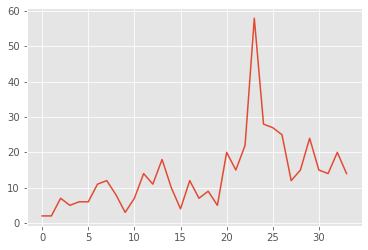

        shop_id  item_id  date_block_num  item_price  item_cnt_day
219720       31     5821              34          34            34
153691       25     4249              34          34            34
190671       28     7894              34          34            34
40169         6    17717              34          34            34


In [6]:
#Check how things plot
df_train_group = df_train.groupby(["date_block_num", "shop_id", "item_id"]).sum().reset_index()

df_plot = df_train_group[(df_train_group.shop_id == 31) & (df_train_group.item_id == 5821)]
plt.plot(df_plot["date_block_num"], df_plot["item_cnt_day"])
plt.show()

new_df = df_train_group.groupby(["shop_id", "item_id"]).count().reset_index()
new_df.sort_values(by=['date_block_num'], ascending=False, inplace=True)

print(new_df.head(4))


In [11]:
df_train_pivot = pd.pivot_table(df_train, values=['item_cnt_day'], index=['shop_id', 'item_id'],
                                columns=['date_block_num'],
                                aggfunc=sum).fillna(0)

df_train_pivot.columns = [col[1] for col in df_train_pivot.columns]
df_train_pivot = df_train_pivot.reset_index()
# add later item_category_id

print(df_train_pivot.head())
print(df_train_pivot.describe().T)

   shop_id  item_id    0     1    2    3    4    5    6    7  ...   24   25  \
0        0       30  0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1        0       31  0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2        0       32  6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3        0       33  3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4        0       35  1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]
            count          mean          std   min     25%      50%      75%  \
shop_id  424123.0     31.431269    16.962058   0.0    18.0     30.0     46.0   
item_id  424123.0  11458.032927  6133.334101   0.0  6244.0  11614.0  16662.0  

In [12]:
from sklearn.model_selection import train_test_split

X = df_train_pivot.drop(columns=[33, "shop_id", "item_id"])
y = df_train_pivot[33]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=1)

In [13]:
# model
model = XGBRegressor(random_state=0)

# Preprocessing of training data, fit model
model.fit(X_train, y_train)
# Preprocessing of validation data, get predictions
preds = model.predict(X_val)

# Evaluate the model
score = mean_absolute_error(y_val, preds)
print('RMAE:', np.sqrt(score))



RMAE: 0.49237263743393134


In [10]:
preds = pd.DataFrame(preds)
preds.to_csv("output/prediction.csv")

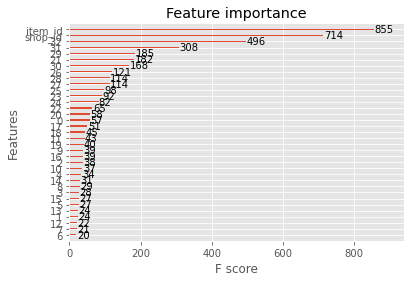

In [11]:
fig, ax = plt.subplots(1,1)
plot_importance(booster=model, ax=ax)


In [32]:
df_test_pivot = pd.merge(df_test, df_train_pivot, on=['item_id', 'shop_id'], how='left').fillna(0)
df_test_pivot = df_test_pivot.drop(columns=["ID"])

In [34]:
X_test = df_test_pivot.drop(columns=0)

X_test.columns = X.columns


(214200, 35)


In [35]:
prediction_test = model.predict(X_test)

print(df_test.shape)
print(prediction_test.shape)

(214200, 3)
(214200,)


In [36]:
output = pd.DataFrame({"ID": df_test["ID"], "item_cnt_month": prediction_test.clip(0, 20)})
output.to_csv("output/submission2.csv",index=False)